# Imperial Valley Dark Fiber DAS Data: Reading, Checking, & Plotting the Data

Prior to running this script, make sure the following are installed within your Python environment:
 - boto3
 - botocore
 - numpy
 - h5py
 - matplotlib
    
After installation, run the following:

In [85]:
import os, sys, logging
import h5py
import boto3
import numpy as np
import s3fs
import matplotlib.pyplot as plt
import matplotlib
import botocore
import io

boto3.set_stream_logger('boto3', logging.INFO)                                                
s3 = boto3.resource('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED)) 
bucket = s3.Bucket('gdr-data-lake')
bucket_name = 'gdr-data-lake'
prefix = 'imperialvalleydas/v1.0.0/'
cwd = os.getcwd()

## Showing Info for Imperial Valley Dark Fiber AWS S3 Bucket

In [94]:
# Total number of objects in Dark Fiber Data
count = 0
for object in bucket.objects.filter(Prefix = prefix):
    count+=1
print('Total count =', count)

# List of all objects in Dark Fiber Data:
#for object in bucket.objects.filter(Prefix = prefix):
    #print(object.key)


Total count = 2881


## Accessing & Checking the Data
This can be done by either pulling the data directly into the notebook from S3, or by first downloading the data locally to your computer and then reading it in. Both approaches are shown below. The final step in this notebook is plotting the data, which works with either approach.

The file used in this tutorial is specified here:

In [87]:
keys = ['DF__UTC_20201113_055632.602.h5'] #You can include multiple files seperated by commas

file_names = ['DF__UTC_20201113_055632.602.h5'] #You can include multiple files seperated by commas


### Read the data directly from S3 and check the metadata

In [88]:
data_stream = []
     
for name in file_names:
    path = f'{prefix}{name}'
    print('Reading:', name)

    obj = s3.Object(bucket_name, path)
    response = obj.get()
    body_bytes = response['Body'].read()

    with io.BytesIO(body_bytes) as f_buffer:
        with h5py.File(f_buffer, 'r') as f:
            dmat = np.array(f['Acoustic'])
            data_stream.append(dmat)

            # Check metadata
            for key1 in f['Acoustic'].attrs.keys():
                print(key1, f['Acoustic'].attrs[key1])

Reading: DF__UTC_20201113_055632.602.h5
Acoustic Output Differential
Attenuator 1 0
Attenuator 2 2.480822
CPUTimeStamp 13/11/2020 05:56:32.304 (UTC)
Continuous Mode True
Decimation Filter True
Defragmented False
Diagnostic Output R, S, As & dP
Diff Amplify Factor 0
Fibre Length Multiplier 1.020952
Fibre Length per Metre 1
FibreIndex 1.4682
GPSTimeStamp 13/11/2020 05:56:32.602 (UTC)
GaugeLength 10
ISO8601 Timestamp 2020-11-13T05:56:32.602+00:00
Integration Cut Off (Hz) 3.14
MeasureLength[m] 27648
Normalization True
OffsetLength 64
OutputDecimation[bool] 4
P 5
P Coefficients 1.00	1.00	1.00	1.00	1.00

Peak Voltage 2 (V) 0
PeakVoltage[V] 2
Power Decrement 0
PreTrigSamples 94
Precise Sampling Frequency (Hz) 2000
Pulse 2 Delay (ns) 500
Pulse Width 2 (ns) 50
PulseWidth[ns] 50
Receiver Gain 160.00	160.00	160.00

Reference Level 1 65535
Reference Level 2 57845
Reference Level 3 62870
Reference length 0
SamplingFrequency[Hz] 500
SavingBandwidth (MB/s) 350
Source Mode Normal
SpatialResolution[m] 

### Checking the data

In [89]:
#Checking the shape of data matrix
print(dmat.shape)

# Checking the data type and some numbers
print(dmat.dtype)
print(dmat[0:10,0:10])

(30000, 6912)
int16
[[-5796 -3171 -4003   161   165  -472  -671  -255   213   -50]
 [ 4279 -6061   603   109   212    59  -622   -84    98    48]
 [-3767 -5142 -1901  -191  -216   121   433   144   -59   -70]
 [ -107   716  9906   281    80  -186   280    46   -27   100]
 [ -509 -3603 -5366  -233  -205    87   157    35   -24   -24]
 [-6325   148  3779   -47   -65   -12  -423  -130   -24   -35]
 [ -568 -3461 -7781   108   -37   499   680   208   -36    87]
 [ 5994 -2695  -600   -53   208  -518  -574  -134    49    13]
 [ 7095   296 -9589  -227  -114  -100   -54   -56    -2  -133]
 [ 3422 16077  4483    71    53    59  -321    22     6    30]]


##### *If you took the above approach for accessing data you can skip to the "Plotting the Data" section*

### Downloading the data locally, and then reading in the data
#### Creating the directory structure for storing the DAS data

In [93]:
#Create a directory
data_dir = cwd+'/DarkFiber_Data'
print(data_dir)
try:
    os.mkdir(data_dir)
except OSError:
    print ("*Creation of the directory %s failed" % data_dir)
else:
    print ("Successfully created the directory %s " % data_dir)

try:
    os.mkdir(data_dir+'/DAS')
except OSError:
    print ("*Creation of the directory %s failed" % data_dir)
else:
    print ("Successfully created the directory %s " % data_dir+'/DAS')

try:
    os.mkdir(data_dir+'/DAS/HDF5')
except OSError:
    print ("*Creation of the directory %s failed" % data_dir)
else:
    print ("Successfully created the directory %s " % data_dir+'/DAS/HDF5')
    
final_dir = data_dir+'/DAS/HDF5/'    
print('Downloaded data will be stored here:',final_dir)

/Users/alowney/Library/CloudStorage/OneDrive-NREL/Desktop/Imperial Valley/DarkFiber_Data
Successfully created the directory /Users/alowney/Library/CloudStorage/OneDrive-NREL/Desktop/Imperial Valley/DarkFiber_Data 
Successfully created the directory /Users/alowney/Library/CloudStorage/OneDrive-NREL/Desktop/Imperial Valley/DarkFiber_Data /DAS
Successfully created the directory /Users/alowney/Library/CloudStorage/OneDrive-NREL/Desktop/Imperial Valley/DarkFiber_Data /DAS/HDF5
Downloaded data will be stored here: /Users/alowney/Library/CloudStorage/OneDrive-NREL/Desktop/Imperial Valley/DarkFiber_Data/DAS/HDF5/


#### Download a Subset of the Dark Fiber DAS Files

The following code block allows the user to download multiple files from AWS from the established list above (in this case we are only downloading one file). 

In [80]:
for index in np.arange(len(keys)):
    key=keys[index]; file_name=file_names[index]
    file_path = final_dir+file_name
    bucket.download_file(prefix+file_name,file_path)
    print(key,'successfully downloaded')

DF__UTC_20201113_055632.602.h5 successfully downloaded


#### Checking the data

In [90]:
f = h5py.File(final_dir+file_name)

print(f)
print(f.keys())
dmat=f['Acoustic']

# CHECKING SHAPE OF DATA MATRIX
print(dmat.shape)
# CHECKING DATA TYPE AND SOME NUMBERS
print(dmat.dtype)
print(dmat[0:10,0:10])


<HDF5 file "DF__UTC_20201113_055632.602.h5" (mode r)>
<KeysViewHDF5 ['Acoustic']>
(30000, 6912)
int16
[[-5796 -3171 -4003   161   165  -472  -671  -255   213   -50]
 [ 4279 -6061   603   109   212    59  -622   -84    98    48]
 [-3767 -5142 -1901  -191  -216   121   433   144   -59   -70]
 [ -107   716  9906   281    80  -186   280    46   -27   100]
 [ -509 -3603 -5366  -233  -205    87   157    35   -24   -24]
 [-6325   148  3779   -47   -65   -12  -423  -130   -24   -35]
 [ -568 -3461 -7781   108   -37   499   680   208   -36    87]
 [ 5994 -2695  -600   -53   208  -518  -574  -134    49    13]
 [ 7095   296 -9589  -227  -114  -100   -54   -56    -2  -133]
 [ 3422 16077  4483    71    53    59  -321    22     6    30]]


In [82]:
print(dmat.name)

# PRINT ALL METADATA
for key1 in dmat.attrs.keys():
    print(key1,dmat.attrs[key1])


/Acoustic
Acoustic Output Differential
Attenuator 1 0
Attenuator 2 2.480822
CPUTimeStamp 13/11/2020 05:56:32.304 (UTC)
Continuous Mode True
Decimation Filter True
Defragmented False
Diagnostic Output R, S, As & dP
Diff Amplify Factor 0
Fibre Length Multiplier 1.020952
Fibre Length per Metre 1
FibreIndex 1.4682
GPSTimeStamp 13/11/2020 05:56:32.602 (UTC)
GaugeLength 10
ISO8601 Timestamp 2020-11-13T05:56:32.602+00:00
Integration Cut Off (Hz) 3.14
MeasureLength[m] 27648
Normalization True
OffsetLength 64
OutputDecimation[bool] 4
P 5
P Coefficients 1.00	1.00	1.00	1.00	1.00

Peak Voltage 2 (V) 0
PeakVoltage[V] 2
Power Decrement 0
PreTrigSamples 94
Precise Sampling Frequency (Hz) 2000
Pulse 2 Delay (ns) 500
Pulse Width 2 (ns) 50
PulseWidth[ns] 50
Receiver Gain 160.00	160.00	160.00

Reference Level 1 65535
Reference Level 2 57845
Reference Level 3 62870
Reference length 0
SamplingFrequency[Hz] 500
SavingBandwidth (MB/s) 350
Source Mode Normal
SpatialResolution[m] 4
Start Distance (m) -126.0209

## Plotting the data

The original data are in INT16 and need to be converted to float or double before any advanced processing

In [91]:
#Convert the data
dmat2=np.float64(dmat)

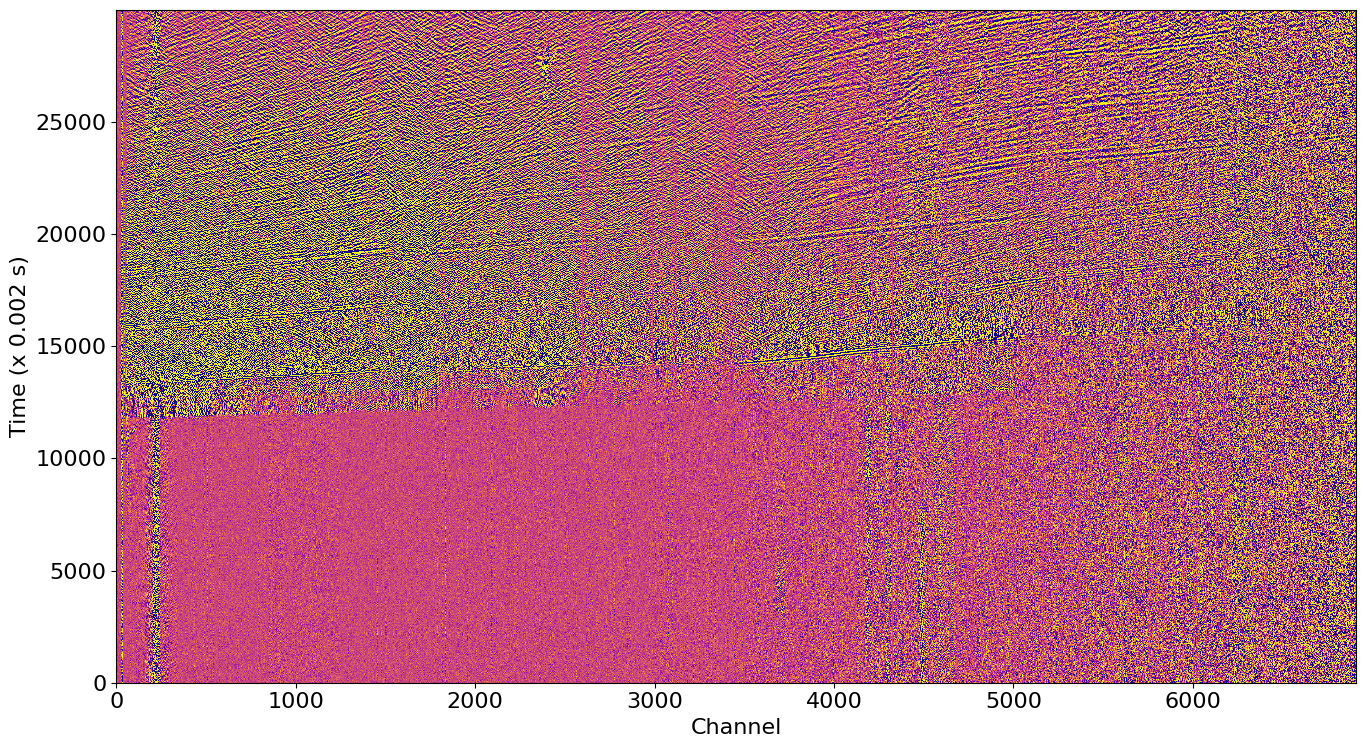

In [92]:
#The data shows P waves from a m2.6 earthquake arrive at the closest channels at 24 seconds
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(16,9))
ax.imshow(dmat2,cmap='plasma',aspect=0.125,vmin=-1000,vmax=1000,interpolation='none')
ax.set_xlabel('Channel')
ax.set_ylabel('Time (x 0.002 s)')
ax.invert_yaxis()